# Regression on predicting hospital costs based on various patient information

# 0. Importing required functions

In [1]:
# Import pandas that allows us to view and manipulate data
import numpy as np
import pandas as pd

# Import scaler
from sklearn.preprocessing import StandardScaler

# Import datasets(s), and function that allows us to do train-test split
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Import model, and functions to perform model evaluation
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.linear_model import LassoCV, RidgeCV

from sklearn.dummy import DummyRegressor

# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

os.chdir('C:\\SP\\Year 1 Sem 2\\Artificial Intelligence and Machine Learning (AIML)\\CA1\\Datasets')

# 1. Preprocessing the dataset

In [3]:
# loading the dataset into df
df = pd.read_csv('CA1-Regression-Dataset.csv') 

df

,ID,Age,Gender,BMI,Smoker,Region,Cost ($)
0,1,19,female,27.900,yes,southwest,16884.92400
1,2,18,male,33.770,no,southeast,1725.55230
2,3,28,male,33.000,no,southeast,4449.46200
3,4,33,male,22.705,no,northwest,21984.47061
4,5,32,male,28.880,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,1334,50,male,30.970,no,northwest,10600.54830
1334,1335,18,female,31.920,no,northeast,2205.98080
1335,1336,18,female,36.850,no,southeast,1629.83350
1336,1337,21,female,25.800,no,southwest,2007.94500


In [4]:
# Show the columns present in the dataset
list(df.columns) 

['ID', 'Age', 'Gender', 'BMI', 'Smoker', 'Region', 'Cost ($)']

### Checking whether the dataset contain any duplicates 

In [5]:
# Check and removing duplicate rows
print("Before dropping duplicates")
print(df.shape)

df = df.drop_duplicates()

print("\nAfter dropping duplicates")
print(df.shape)

Before dropping duplicates
(1338, 7)

After dropping duplicates
(1338, 7)


Since the shape of the dataset didn't change after drop.duplicates, I can safely conclude that there isn't any duplicate data in the dataset.

### Checking if the dataset contain any missing values

<Axes: >

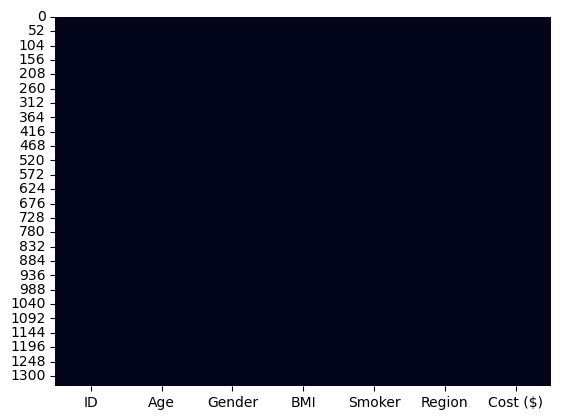

In [6]:
# Heatmap showing missing values(in white)
sns.heatmap(df.isnull(), cbar = False) 

In [7]:
# Sum of total missing values in the data
df.isnull().sum()

ID          0
Age         0
Gender      0
BMI         0
Smoker      0
Region      0
Cost ($)    0
dtype: int64

Since there isn't any missing values in the data, we don't need to impute any.

### Checking for outliers 

Since only Age, BMI, Cost ($) contain continuous quantitative data, we will only check for outliers on these 3 columns.

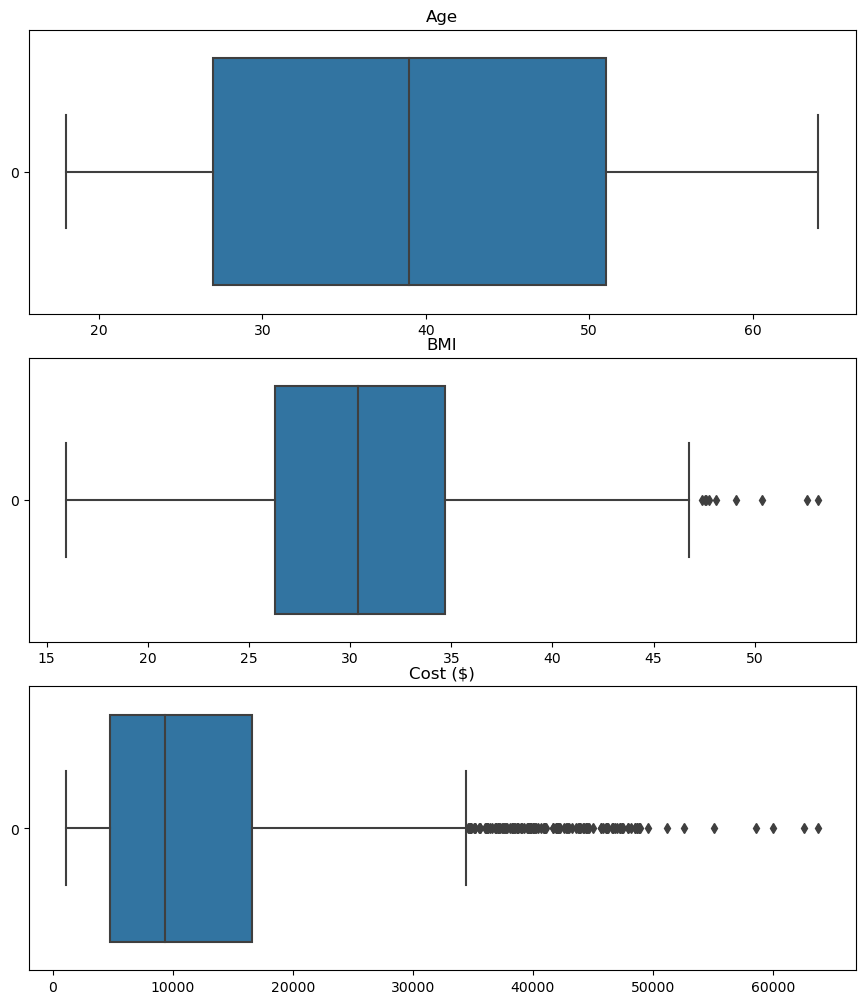

In [8]:
column_list_values = list(df[['Age', 'BMI', 'Cost ($)']])

# Initializing a figure to store the individual boxplots
fig, axes = plt.subplots(3, figsize=(9,10))
fig.tight_layout()

# Plotting boxplots for all the features in the dataset
index = 0
for column in column_list_values:
    sns.boxplot(ax=axes[index], data=df[column], orient='h').set_title(column)
    index += 1

After plotting boxplots for all the features present in the dataset, we can identify the outliers by the black diamond markers present outside of the whiskers of the interquartile range. In the above plots, we can see that all features contain outliers, therefore we should find a solution to remove these outliers. The reason why outliers need to be removed is because:

- It may cause a significant impact on the mean and the standard deviation. If the outliers are non-randomly distributed, they can decrease normality. They can bias or influence estimates that may be of substantive interest.

Since I have no idea how the outliers would affect my model, I have decided not to remove outliers in this dataset.

### Creating dummy variables  

In [9]:
# Create dummies for categorical values (Smoker, Gender, Region)
df = pd.get_dummies(df, drop_first=True, dtype=int)

df

,ID,Age,BMI,Cost ($),Gender_male,Smoker_yes,Region_northwest,Region_southeast,Region_southwest
0,1,19,27.900,16884.92400,0,1,0,0,1
1,2,18,33.770,1725.55230,1,0,0,1,0
2,3,28,33.000,4449.46200,1,0,0,1,0
3,4,33,22.705,21984.47061,1,0,1,0,0
4,5,32,28.880,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,1334,50,30.970,10600.54830,1,0,1,0,0
1334,1335,18,31.920,2205.98080,0,0,0,0,0
1335,1336,18,36.850,1629.83350,0,0,0,1,0
1336,1337,21,25.800,2007.94500,0,0,0,0,1


After creating new dummy variables for Gender, Smoker, Regions, we will remove the Gender, Smoker, Regions columns and use the newly created dummy variables in our data.

# 2. Train-test split

Since this is a regression problem, I will therefore only use regression models:
- Linear Regression
- Decision Tree Regressor
- Support Vector Regresso (SVR)

There will be 2 methods on how I am working on this regression assignment:
1. Use all features to train the models 

2. Use Lasso CV to find which features are important, and train the important features into the models

## (a) Spilting the data into training and testing sets 

In [10]:
X = df.drop(labels=['Cost ($)', 'ID'], axis=1)
y = df['Cost ($)']

I'm dropping the target column 'Cost' as it will be the testing set of the dataset. I'm also dropping the 'ID' column since it has no correlation with the ability of predicting 'Cost' since it's just a index.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                    random_state=42)

In [12]:
# Initialize the Standard Scaler
scaler = StandardScaler()

X_train[['Age', 'BMI']] = scaler.fit_transform(X_train[['Age', 'BMI']])
X_test[['Age', 'BMI']] = scaler.transform(X_test[['Age', 'BMI']])

Since Age and BMI are the only columns with continuous data, I will only be scaling these 2 columns. The rest of the columns are either binary values, such as 1 and 0, or is the target column 'Cost'.

## Method 2: Using important features chosen by Lasso CV

In [13]:
# 5-Folds CV
kf = KFold(n_splits = 5) 

### Lasso CV Regression 

In [14]:
alphas = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.4, 0.5, 1, 10, 50, 100]

lasso_cv = LassoCV(alphas = alphas, cv=kf, random_state=42)
lasso_cv.fit(X_train, y_train)

y_pred_lasso = lasso_cv.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso CV - Best Alpha: {lasso_cv.alpha_} \nMSE: {mse_lasso} \nR2: {r2_lasso}")
print(f"Intercept: {lasso_cv.intercept_}")
print(f"Coefficients: {lasso_cv.coef_}")

Lasso CV - Best Alpha: 100.0 
MSE: 34730152.80078858 
R2: 0.776293484223226
Intercept: 8607.01205796386
Coefficients: [ 3546.56273691  1883.21144719     0.         23049.15052677
     0.            -0.            -0.        ]


The coefficients with postive values mean that the Lasso CV treats that as an important feature, and thus I will include it in the X and y. On the contrary, the coefficients with 0 and negative numbers mean that Lasso CV thinks that the feature is redundant, therefore I will be removing them.
- I only be taking the 'Age', 'BMI', 'Smoker_yes' for method 2

### New train-test split

In [15]:
X_train_m2 = X_train[['Age', 'BMI', 'Smoker_yes']]

X_test_m2 = X_test[['Age', 'BMI', 'Smoker_yes']]

Taking only the 3 columns that Lasso CV thinks is important

Now I have the required items for method 1 and method 2.
Method 1:
- X_train
- X_test

Method 2:
- X_train_m2
- X_test_m2

# 3. Training the models 

### (a) Linear Regression 

In [16]:
# ----------- Method 1 -----------

# Fit a linear regression model to the data
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

# Make predictions
y_pred = LR_model.predict(X_test)

# Summarize the fit of the model
LR_mape = round(mean_absolute_percentage_error(y_test, y_pred), 2)
LR_mse = round(mean_squared_error(y_test, y_pred), 2)
LR_r2 = round(r2_score(y_test, y_pred), 2)

print("----------- Method 1 -----------")
print(f'Linear Regression Mean Absolute Percentage Error: {LR_mape}')
print(f'Linear Regression Mean Squared Error: {LR_mse}')
print(f'Linear Regression R-squared: {LR_r2}')

# ----------- Method 2 -----------

# Fit a linear regression model to the data
LR_model_m2 = LinearRegression()
LR_model_m2.fit(X_train_m2, y_train)

# Make predictions
y_pred_m2 = LR_model_m2.predict(X_test_m2)

# Summarize the fit of the model
LR_mape_m2 = round(mean_absolute_percentage_error(y_test, y_pred_m2), 2)
LR_mse_m2 = round(mean_squared_error(y_test, y_pred_m2), 2)
LR_r2_m2 = round(r2_score(y_test, y_pred_m2), 2)

print("\n----------- Method 2 -----------")
print(f'Linear Regression Mean Absolute Percentage Error: {LR_mape_m2}')
print(f'Linear Regression Mean Squared Error: {LR_mse_m2}')
print(f'Linear Regression R-squared: {LR_r2_m2}')

----------- Method 1 -----------
Linear Regression Mean Absolute Percentage Error: 0.48
Linear Regression Mean Squared Error: 34142364.8
Linear Regression R-squared: 0.78

----------- Method 2 -----------
Linear Regression Mean Absolute Percentage Error: 0.5
Linear Regression Mean Squared Error: 34512843.88
Linear Regression R-squared: 0.78


Linear Regression - Method 1 is better

### Tuning hyperparameters of Linear Regression

In [17]:
# Initializing the LogisticRegression model
tuned_LR_model = LinearRegression()

# Create the parameter space
params = {"fit_intercept": [True, False], 
          "positive": [True, False]}

# Instantiate the GridSearchCV object
tuned_LR_model = GridSearchCV(tuned_LR_model, params, cv=kf, scoring = "r2")

# Fit the data to the model
tuned_LR_model.fit(X_train, y_train)


# Print the tuned parameters and score
print("Linear Regression Best Parameters: {}".format(tuned_LR_model.best_params_)) 

print("\nLinear Regression r2 score: {}".format(tuned_LR_model.best_score_)) 

Linear Regression Best Parameters: {'fit_intercept': True, 'positive': True}

Linear Regression r2 score: 0.732525891024525


In [18]:
# ----------- Method 1 -----------
m1_LR_model = LinearRegression(fit_intercept = True, 
                                  positive = True)

m1_LR_scores = cross_val_score(m1_LR_model, X_train, y_train, cv=kf, scoring = "r2")

# Calculating the results
m1_LR_mean_scores = round(m1_LR_scores.mean(), 2)
print("\n----------- Method 1 -----------")
print(f'Tuned Linear Regression r2 Score: ', m1_LR_mean_scores)


----------- Method 1 -----------
Tuned Linear Regression r2 Score:  0.73


### (b) Decision Tree Regressor

In [19]:
# ----------- Method 1 -----------
DT_model = DecisionTreeRegressor(random_state=42)
DT_model.fit(X_train, y_train)

# Make predictions
y_pred = DT_model.predict(X_test)

# Summarize the fit of the model
DT_mape = round(mean_absolute_percentage_error(y_test, y_pred), 2)
DT_mse = round(mean_squared_error(y_test, y_pred), 2)
DT_r2 = round(r2_score(y_test, y_pred), 2)

print("\n----------- Method 1 -----------")
print(f'Decision Tree Regressor Mean Absolute Percentage Error: {DT_mape}')
print(f'Decision Tree Regressor Mean Squared Error: {DT_mse}')
print(f'Decision Tree Regressor R-squared: {DT_r2}')


# ----------- Method 2 -----------
DT_model_m2 = DecisionTreeRegressor(random_state=42)
DT_model_m2.fit(X_train_m2, y_train)

# Make predictions
y_pred_m2 = DT_model_m2.predict(X_test_m2)

# Summarize the fit of the model
DT_mape_m2 = round(mean_absolute_percentage_error(y_test, y_pred_m2), 2)
DT_mse_m2 = round(mean_squared_error(y_test, y_pred_m2), 2)
DT_r2_m2 = round(r2_score(y_test, y_pred_m2), 2)

print("\n----------- Method 2 -----------")
print(f'Decision Tree Regressor Mean Absolute Percentage Error: {DT_mape_m2}')
print(f'Decision Tree Regressor Mean Squared Error: {DT_mse_m2}')
print(f'Decision Tree Regressor R-squared: {DT_r2_m2}')


----------- Method 1 -----------
Decision Tree Regressor Mean Absolute Percentage Error: 0.44
Decision Tree Regressor Mean Squared Error: 46950261.17
Decision Tree Regressor R-squared: 0.7

----------- Method 2 -----------
Decision Tree Regressor Mean Absolute Percentage Error: 0.4
Decision Tree Regressor Mean Squared Error: 40126732.15
Decision Tree Regressor R-squared: 0.74


Decision Tree Regressor - Method 2 is better

### Tuning hyperparameters of Decision Tree Regressor

In [20]:
# Initializing the DecisionTreeRegressor model
tuned_DT_model = DecisionTreeRegressor()

# Create the parameter space
params = {'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8]
         }

# Instantiate the RandomizedSearchCV object
tuned_DT_model = RandomizedSearchCV(tuned_DT_model, params, cv=kf, scoring = "r2")

# Fit the data to the model
tuned_DT_model.fit(X_train_m2, y_train)


# Print the tuned parameters and score
print("Decision Tree Regression Best Parameters: {}".format(tuned_DT_model.best_params_)) 

print("\nDecision Tree Regression r2 score: {}".format(tuned_DT_model.best_score_)) 

Decision Tree Regression Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 8, 'max_depth': 10}

Decision Tree Regression r2 score: 0.8194839040681494


In [21]:
# ----------- Method 2 -----------
# Fitting and training the actual model
tuned_DT_model = DecisionTreeRegressor(min_samples_split = 10, 
                      min_samples_leaf = 8, 
                      max_depth = 10)

tuned_DT_scores = cross_val_score(tuned_DT_model, X_train_m2, y_train, cv=kf, scoring = "r2")

# Calculating the results
tuned_DT_mean_scores = round(tuned_DT_scores.mean(), 2)

print("----------- Method 2 -----------")
print(f'Decision Tree Regressor r2 Score: ', tuned_DT_mean_scores)

----------- Method 2 -----------
Decision Tree Regressor r2 Score:  0.82


### (c) Random Forest Regressor

In [22]:
# ----------- Method 1 -----------
RF_model = RandomForestRegressor(random_state=42)
RF_model.fit(X_train, y_train)

# Make predictions
y_pred = RF_model.predict(X_test)

# Summarize the fit of the model
RF_mape = round(mean_absolute_percentage_error(y_test, y_pred), 2)
RF_mse = round(mean_squared_error(y_test, y_pred), 2)
RF_r2 = round(r2_score(y_test, y_pred), 2)

print("----------- Method 1 -----------")
print(f'Random Forest Regressor Mean Absolute Percentage Error: {RF_mape}')
print(f'Random Forest Regressor Mean Squared Error: {RF_mse}')
print(f'Random Forest Regressor R-squared: {RF_r2}')


# ----------- Method 2 -----------
RF_model = RandomForestRegressor(random_state=42)
RF_model.fit(X_train_m2, y_train)

# Make predictions
y_pred_m2 = RF_model.predict(X_test_m2)

# Summarize the fit of the model
RF_mape_m2 = round(mean_absolute_percentage_error(y_test, y_pred_m2), 2)
RF_mse_m2 = round(mean_squared_error(y_test, y_pred_m2), 2)
RF_r2_m2 = round(r2_score(y_test, y_pred_m2), 2)

print("\n----------- Method 2 -----------")
print(f'Random Forest Regressor Mean Absolute Percentage Error: {RF_mape_m2}')
print(f'Random Forest Regressor Mean Squared Error: {RF_mse_m2}')
print(f'Random Forest Regressor R-squared: {RF_r2_m2}')

----------- Method 1 -----------
Random Forest Regressor Mean Absolute Percentage Error: 0.38
Random Forest Regressor Mean Squared Error: 22595882.16
Random Forest Regressor R-squared: 0.85

----------- Method 2 -----------
Random Forest Regressor Mean Absolute Percentage Error: 0.4
Random Forest Regressor Mean Squared Error: 25733119.22
Random Forest Regressor R-squared: 0.83


Random Forest Regressor - Method 1 is better
Since MSE and MAPE of method 1 is lower compared to those of method 2

In [23]:
# Initializing the Random Forest Regressor model
tuned_RF_model = RandomForestRegressor()

# Create the parameter space
params = {'max_depth': [None, 10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4]
         }

# Instantiate the RandomizedSearchCV object
tuned_RF_model = RandomizedSearchCV(tuned_RF_model, params, cv=kf, scoring = "r2")

# Fit the data to the model
tuned_RF_model.fit(X_train, y_train)


# Print the tuned parameters and score
print("Random Forest Regressor Best Parameters: {}".format(tuned_RF_model.best_params_)) 

print("\nRandom Forest Regressor r2 score: {}".format(tuned_RF_model.best_score_)) 

Random Forest Regressor Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}

Random Forest Regressor r2 score: 0.8370682735563845


In [24]:
# ----------- Method 1 -----------
tuned_RF_model =RandomForestRegressor(min_samples_split = 5, 
                      min_samples_leaf = 4, 
                      max_depth = 10)

tuned_RF_scores = cross_val_score(tuned_RF_model, X_train, y_train, cv=kf, scoring = "r2")

# Calculating the results
tuned_RF_mean_scores = round(tuned_RF_scores.mean(), 2)

print("----------- Method 1 -----------")
print(f'Random Forest Regressor r2 Score: ', tuned_RF_mean_scores)

----------- Method 1 -----------
Random Forest Regressor r2 Score:  0.84


### (d) Ridge CV

In [25]:
alphas = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.4, 0.5, 1, 10, 50, 100]

# ------------- Method 1 -------------
ridge_cv = RidgeCV(alphas = alphas, cv=kf)
ridge_cv.fit(X_train, y_train)

y_pred_ridge = ridge_cv.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("----------- Method 1 -----------")
print(f"Lasso CV - Best Alpha: {ridge_cv.alpha_} \nMSE: {mse_ridge} \nR2: {r2_ridge}")
print(f"Intercept: {ridge_cv.intercept_}")
print(f"Coefficients: {ridge_cv.coef_}")


# ------------- Method 2 -------------
ridge_cv_m2 = RidgeCV(alphas = alphas, cv=kf)
ridge_cv_m2.fit(X_train_m2, y_train)

y_pred_ridge_m2 = ridge_cv_m2.predict(X_test_m2)

mse_ridge_m2 = mean_squared_error(y_test, y_pred_ridge_m2)
r2_ridge_m2 = r2_score(y_test, y_pred_ridge_m2)

print("\n----------- Method 2 -----------")
print(f"Lasso CV - Best Alpha: {ridge_cv_m2.alpha_} \nMSE: {mse_ridge_m2} \nR2: {r2_ridge_m2}")
print(f"Intercept: {ridge_cv_m2.intercept_}")
print(f"Coefficients: {ridge_cv_m2.coef_}")

----------- Method 1 -----------
Lasso CV - Best Alpha: 1.0 
MSE: 34188462.481044754 
R2: 0.7797826613297876
Intercept: 8955.305963467159
Coefficients: [ 3.64121965e+03  2.03020307e+03  5.74856516e+00  2.35371417e+04
 -3.32458150e+02 -6.59025893e+02 -8.01398233e+02]

----------- Method 2 -----------
Lasso CV - Best Alpha: 0.5 
MSE: 34529782.11809133 
R2: 0.7775841271854705
Intercept: 8492.22502470644
Coefficients: [ 3646.16729948  1971.28798857 23607.43291579]


### (e) Dummy Regressor

In [26]:
# ----------- Method 1 -----------
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

# Make predictions
y_pred = dummy_model.predict(X_test)

# Summarize the fit of the model
dummy_mape = round(mean_absolute_percentage_error(y_test, y_pred), 2)
dummy_mse = round(mean_squared_error(y_test, y_pred), 2)
dummy_r2 = round(r2_score(y_test, y_pred), 2)

print("----------- Method 1 -----------")
print(f'Dummy Regressor Mean Absolute Percentage Error: {dummy_mape}')
print(f'Dummy Regressor Mean Squared Error: {dummy_mse}')
print(f'Dummy Regressor R-squared: {dummy_r2}')


# ----------- Method 2 -----------
dummy_model = DummyRegressor()
dummy_model.fit(X_train_m2, y_train)

# Make predictions
y_pred_m2 = dummy_model.predict(X_test_m2)

# Summarize the fit of the model
dummy_mape_m2 = round(mean_absolute_percentage_error(y_test, y_pred_m2), 2)
dummy_mse_m2 = round(mean_squared_error(y_test, y_pred_m2), 2)
dummy_r2_m2 = round(r2_score(y_test, y_pred_m2), 2)

print("\n----------- Method 2 -----------")
print(f'Dummy Regressor Mean Absolute Percentage Error: {dummy_mape_m2}')
print(f'Dummy Regressor Mean Squared Error: {dummy_mse_m2}')
print(f'Dummy Regressor R-squared: {dummy_r2_m2}')

----------- Method 1 -----------
Dummy Regressor Mean Absolute Percentage Error: 1.68
Dummy Regressor Mean Squared Error: 155391443.68
Dummy Regressor R-squared: -0.0

----------- Method 2 -----------
Dummy Regressor Mean Absolute Percentage Error: 1.68
Dummy Regressor Mean Squared Error: 155391443.68
Dummy Regressor R-squared: -0.0


Dummy Regressor - Both method produces the same results

In [27]:
# Initializing the Dummy Regressor model
tuned_dummy_model = DummyRegressor()

# Create the parameter space
params = {'strategy': ['mean', 'median', 'quantile', 'constant']}


# Instantiate the RandomizedSearchCV object
tuned_dummy_model = RandomizedSearchCV(tuned_dummy_model, params, cv=kf, scoring = "r2")

# Fit the data to the model
tuned_dummy_model.fit(X_train, y_train)


# Print the tuned parameters and score
print("Dummy Regressor Best Parameters: {}".format(tuned_dummy_model.best_params_)) 

print("\nDummy Regressor r2 score: {}".format(tuned_dummy_model.best_score_)) 

Dummy Regressor Best Parameters: {'strategy': 'mean'}

Dummy Regressor r2 score: -0.004796192893767958


In [28]:
tuned_dummy_model = DummyRegressor(strategy = 'mean')

tuned_dummy_scores = cross_val_score(tuned_dummy_model, X_train, y_train, cv=kf, scoring = "r2")

# Calculating the results
tuned_dummy_mean_scores = round(tuned_dummy_scores.mean(), 3)

print(f'Dummy Regressor r2 Score: ', tuned_dummy_mean_scores)

Dummy Regressor r2 Score:  -0.005


# 4. Evaluating the tuned models

To compare and find out which models are the best, I will be using fitting and cross validation to find out the model's r2_score, mean squared error and mean absolute error. Compare with all the other models to see which one's the best model overall.

Since when using both the mean absolute error and mean squared error as scoring in cross_val_score, the scores output will be negative. Therefore, we wil, have to apply abs() to obtain the positive values of both scoring to assist us to evaluate the model.

### Random Forest Regressor - Method 1

In [29]:
test_RF_model = RandomForestRegressor(min_samples_split = 5, 
                          min_samples_leaf = 4, 
                          max_depth = 10)

test_RF_mape = cross_val_score(test_RF_model, X_train, y_train, cv=kf, scoring = "neg_mean_absolute_error")
test_RF_mse = cross_val_score(test_RF_model, X_train, y_train, cv=kf, scoring = "neg_mean_squared_error")
test_RF_r2 = cross_val_score(test_RF_model, X_train, y_train, cv=kf, scoring = "r2")

print("----------- Random Forest Regressor (Test set) -----------")
print(f'Random Forest Regressor Mean Absolute Percentage Error: {round(abs(np.mean(test_RF_mape)), 3)}')
print(f'Random Forest Regressor Mean Squared Error: {round(abs(np.mean(test_RF_mse)), 3)}')
print(f'Random Forest Regressor R-squared: {round(np.mean(test_RF_r2), 3)}')

----------- Random Forest Regressor (Test set) -----------
Random Forest Regressor Mean Absolute Percentage Error: 2779.762
Random Forest Regressor Mean Squared Error: 23184622.516
Random Forest Regressor R-squared: 0.836


### Decision Tree Regressor - Method 2

In [30]:
test_DT_model = DecisionTreeRegressor(min_samples_split = 5, 
                          min_samples_leaf = 4, 
                          max_depth = 10)

test_DT_mape = cross_val_score(test_DT_model, X_train_m2, y_train, cv=kf, scoring = "neg_mean_absolute_error")
test_DT_mse = cross_val_score(test_DT_model, X_train_m2, y_train, cv=kf, scoring = "neg_mean_squared_error")
test_DT_r2 = cross_val_score(test_DT_model, X_train_m2, y_train, cv=kf, scoring = "r2")


print("----------- Decision Tree Regressor (test set) -----------")
print(f'Decision Tree Regressor Mean Absolute Percentage Error: {round(abs(np.mean(test_DT_mape)), 3)}')
print(f'Decision Tree Regressor Mean Squared Error: {round(abs(np.mean(test_DT_mse)), 3)}')
print(f'Decision Tree Regressor R-squared: {round(np.mean(test_DT_r2), 3)}')

----------- Decision Tree Regressor (test set) -----------
Decision Tree Regressor Mean Absolute Percentage Error: 2883.326
Decision Tree Regressor Mean Squared Error: 27427848.273
Decision Tree Regressor R-squared: 0.807


### Linear Regression - Method 1

In [31]:
test_LR_model = LinearRegression(fit_intercept = True, 
                                  positive = True)

test_LR_mape = cross_val_score(test_LR_model, X_train, y_train, cv=kf, scoring = "neg_mean_absolute_error")
test_LR_mse = cross_val_score(test_LR_model, X_train, y_train, cv=kf, scoring = "neg_mean_squared_error")
test_LR_r2 = cross_val_score(test_LR_model, X_train, y_train, cv=kf, scoring = "r2")

print("----------- Linear Regression (test set) -----------")
print(f'Linear Regression Mean Absolute Percentage Error: {round(abs(np.mean(test_LR_mape)), 3)}')
print(f'Linear Regression Mean Squared Error: {round(abs(np.mean(test_LR_mse)), 3)}')
print(f'Linear Regression R-squared: {round(np.mean(test_LR_r2), 3)}')

----------- Linear Regression (test set) -----------
Linear Regression Mean Absolute Percentage Error: 4261.88
Linear Regression Mean Squared Error: 38024590.537
Linear Regression R-squared: 0.733


### Dummy Regressor - Method 1 

In [32]:
test_dummy_model = DummyRegressor(strategy = 'mean')

test_dummy_mape = cross_val_score(test_dummy_model, X_train, y_train, cv=kf, scoring = "neg_mean_absolute_error")
test_dummy_mse = cross_val_score(test_dummy_model, X_train, y_train, cv=kf, scoring = "neg_mean_squared_error")
test_dummy_r2 = cross_val_score(test_dummy_model, X_train, y_train, cv=kf, scoring = "r2")

print("----------- Dummy Regressor (test set) -----------")
print(f'Dummy Regressor Mean Absolute Percentage Error: {round(abs(np.mean(test_dummy_mape)), 3)}')
print(f'Dummy Regressor Mean Squared Error: {round(abs(np.mean(test_dummy_mse)), 3)}')
print(f'Dummy Regressor R-squared: {round(np.mean(test_dummy_r2), 3)}')

----------- Dummy Regressor (test set) -----------
Dummy Regressor Mean Absolute Percentage Error: 9004.21
Dummy Regressor Mean Squared Error: 144597530.03
Dummy Regressor R-squared: -0.005


# 5. Final Model 

## Best Regression Model - Random Forest Regressor 

After completing the steps to get to here, Random Forest Regressor seems to be the best model out of all the models being tested. Random Forest Regressor has the lowest Mean Absolute Percentage Error, lowest Random Forest Regressor Mean Squared Error and the highest R-squared that is close to 1.

- Random Forest Regressor Mean Absolute Percentage Error: 2780.799
- Random Forest Regressor Mean Squared Error: 23191368.417
- Random Forest Regressor R-squared: 0.837

Additionally, the Random Forest Regressor has a higher Mean Absolute Percentage Error, Mean Squared Error and R-squared compared to the dummy regressor model, thus proving that my system is better compared to the dummy model.

## Fitting Tuned Random Forest Regressor

In [33]:
final_RF_model = RandomForestRegressor(min_samples_split = 5, 
                          min_samples_leaf = 4, 
                          max_depth = 10)
final_RF_model.fit(X_train, y_train)

# Make prediction
final_y_pred = final_RF_model.predict(X_test)

# Summarize the fit of the model
final_RF_mape = round(mean_absolute_error(y_test, final_y_pred), 2)
final_RF_mse = round(mean_squared_error(y_test, final_y_pred), 2)
final_RF_r2 = round(r2_score(y_test, final_y_pred), 2)

print("Final Random Forest Regressor")
print(f'The model Mean Absolute Percentage Error: {final_RF_mape}')
print(f'The model Mean Squared Error: {final_RF_mse}')
print(f'The model r-squared: {final_RF_r2}')

Final Random Forest Regressor
The model Mean Absolute Percentage Error: 2666.23
The model Mean Squared Error: 20977933.33
The model r-squared: 0.86
